## Tree-Based Models for a Regression Problem and Hyperparameter Tuning

We continue to work with our review dataset to see how Tree-based regressors (Decision Tree, Random Forest), along with efficient optimization techniques (GridSearch, RandomizedSearch), perform to predict the __log_votes__ field of the dataset.

* Find more details on the DecisionTreeRegressor here: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

* Find more details on the RandomForestRegressor here: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

* Find more details on the GridSearchCV here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

* Find more details on the RandomizedSearchCV here: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

Overall dataset schema:
* __reviewText:__ Text of the review
* __summary:__ Summary of the review
* __verified:__ Whether the purchase was verified (True or False)
* __time:__ UNIX timestamp for the review
* __rating:__ Rating of the review
* __log_votes:__ Logarithm-adjusted votes log(1+votes)


### 1. Reading the dataset

We will use the __pandas__ library to read our dataset.

In [2]:
import pandas as pd
from sklearn.utils import shuffle

df = pd.read_csv('../../DATA/NLP/EMBK-NLP-REVIEW-DATA-CSV.csv')

print('The shape of the dataset is:', df.shape)

The shape of the dataset is: (55000, 6)


Let's look at the first five rows in the dataset. As you can see the __log_votes__ field is numeric. That's why we will build a regression model.

In [3]:
df.head()

,reviewText,summary,verified,time,rating,log_votes
0,"Stuck with this at work, slow and we still got...",Use SEP or Mcafee,False,1464739200,1.0,0.0
1,I use parallels every day with both my persona...,Use it daily,False,1332892800,5.0,0.0
2,Barbara Robbins\n\nI've used TurboTax to do ou...,Helpful Product,True,1398816000,4.0,0.0
3,I have been using this software security for y...,Five Stars,True,1430784000,5.0,0.0
4,If you want your computer hijacked and slowed ...,... hijacked and slowed to a crawl Windows 10 ...,False,1508025600,1.0,0.0


### 2. Exploratory Data Analysis and Missing Value Imputation

Let's look at the range and distribution of log_votes

In [4]:
df["log_votes"].min()

0.0

In [5]:
df["log_votes"].max()

7.799753318287247

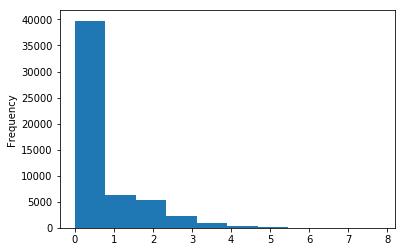

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

df["log_votes"].plot.hist()
plt.show()

We can check the number of missing values for each columm below.

In [7]:
print(df.isna().sum())

reviewText    6
summary       7
verified      0
time          0
rating        0
log_votes     0
dtype: int64


Let's fill-in the missing values for reviewText below. We will just use the placeholder "Missing" here.

In [8]:
df["reviewText"].fillna("Missing", inplace=True)

### 3. Stop Word Removal and Stemming

In [9]:
# Install the library and functions
import nltk

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

We will create the stop word removal and text cleaning processes below. NLTK library provides a list of common stop words. We will use the list, but remove some of the words from that list (because those words are actually useful to understand the sentiment in the sentence).

In [10]:
import nltk, re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# Let's get a list of stop words from the NLTK library
stop = stopwords.words('english')

# These words are important for our problem. We don't want to remove them.
excluding = ['against', 'not', 'don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
             'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
             'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",'shouldn', "shouldn't", 'wasn',
            "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
# New stop word list
stop_words = [word for word in stop if word not in excluding]

snow = SnowballStemmer('english')

def process_text(texts): 
    final_text_list=[]
    for sent in texts:
        filtered_sentence=[]
        
        sent = sent.lower() # Lowercase 
        sent = sent.strip() # Remove leading/trailing whitespace
        sent = re.sub('\s+', ' ', sent) # Remove extra space and tabs
        sent = re.compile('<.*?>').sub('', sent) # Remove HTML tags/markups:
        
        for w in word_tokenize(sent):
            # We are applying some custom filtering here, feel free to try different things
            # Check if it is not numeric and its length>2 and not in stop words
            if(not w.isnumeric()) and (len(w)>2) and (w not in stop_words):  
                # Stem and add to filtered list
                filtered_sentence.append(snow.stem(w))
        final_string = " ".join(filtered_sentence) #final string of cleaned words
 
        final_text_list.append(final_string)
    
    return final_text_list

In [11]:
print("Pre-processing the reviewText field")
df["reviewText"] = process_text(df["reviewText"].tolist()) 


Pre-processing the reviewText field


### 4. Scaling numerical fields:

We will apply min-max scaling to our rating field so that they will be between 0-1.

In [12]:
df["rating"] = (df["rating"] - df["rating"].min())/ (df["rating"].max()-df["rating"].min())
df["time"] = (df["time"] - df["time"].min())/ (df["time"].max()-df["time"].min())

### 5. Splitting the training dataset into training and validation

Sklearn library has a useful function to split datasets. We will use the __train_test_split()__ function. In the example below, we get 90% of the data for training and 10% is left for validation.

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df[["reviewText", "rating", "time"]], # Using these three fields
                                                  df["log_votes"].tolist(),  # Target field
                                                  test_size=0.10,  # 10% test, 90% tranining
                                                  shuffle=True # Shuffle the whole dataset
                                                 )

### 6. Computing Bag of Words Features

We are using binary features here. TF and TF-IDF are other options.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Initialize the binary count vectorizer
tfidf_vectorizer = CountVectorizer(binary=True,
                                   max_features=50    # Limit the vocabulary size
                                  )

X_train_text_vectors = tfidf_vectorizer.fit_transform(X_train["reviewText"].tolist()) # Fit and transform
X_val_text_vectors = tfidf_vectorizer.transform(X_val["reviewText"].tolist())       # Only transform

Let's print our vocabulary below. The number next to the word is its index in the vocabulary.

In [15]:
tfidf_vectorizer.vocabulary_

{'work': 47,
 'great': 13,
 'price': 25,
 'get': 11,
 'softwar': 33,
 'look': 17,
 'new': 22,
 'run': 32,
 'time': 36,
 'find': 10,
 'use': 39,
 'good': 12,
 'buy': 3,
 'not': 23,
 'realli': 30,
 'much': 20,
 'year': 49,
 'instal': 15,
 'would': 48,
 'also': 0,
 'comput': 4,
 'problem': 26,
 'version': 42,
 'need': 21,
 'tri': 37,
 'download': 6,
 'purchas': 29,
 'product': 27,
 'upgrad': 38,
 'support': 35,
 'help': 14,
 'make': 18,
 'back': 1,
 'program': 28,
 'even': 8,
 'well': 45,
 'still': 34,
 'easi': 7,
 'like': 16,
 'user': 40,
 'way': 44,
 'mani': 19,
 'recommend': 31,
 'one': 24,
 'window': 46,
 'file': 9,
 'want': 43,
 've': 41,
 'could': 5,
 'better': 2}

Let's merge our features to train a model.

In [16]:
import numpy as np
X_train_features = np.column_stack((X_train_text_vectors.toarray(), 
                                    X_train["rating"].values, 
                                    X_train["time"].values)
                                  )
X_val_features = np.column_stack((X_val_text_vectors.toarray(), 
                                  X_val["rating"].values,
                                  X_val["time"].values)
                                )

### 7. Fitting tree-based regressors and checking the validation performance

#### 7.1  DecisionTreeRegressor
Let's first fit a __DecisionTreeRegressor__ from Sklearn library, and check the performance on the validation dataset.

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html


In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error

dtRegressor = DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 15)
dtRegressor.fit(X_train_features, y_train)
dtRegressor_val_predictions = dtRegressor.predict(X_val_features)
print("DecisionTreeRegressor on Validation: R_square_score: %f, Mean_squared_error: %f" % (r2_score(y_val, dtRegressor_val_predictions), mean_squared_error(y_val, dtRegressor_val_predictions)))


DecisionTreeRegressor on Validation: R_square_score: 0.305673, Mean_squared_error: 0.646136


#### 7.2  RandomForestRegressor
Let's now fit a __RandomForestRegressor__ from Sklearn library, and check the performance on the validation dataset.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html


In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

rfRegressor = RandomForestRegressor(n_estimators = 200, max_depth = 10, min_samples_leaf = 15)
rfRegressor.fit(X_train_features, y_train)
rfRegressor_val_predictions =rfRegressor.predict(X_val_features)
print("RandomForestRegressor on Validation: R_square_score: %f, Mean_squared_error: %f" % (r2_score(y_val, rfRegressor_val_predictions), mean_squared_error(y_val, rfRegressor_val_predictions)))


RandomForestRegressor on Validation: R_square_score: 0.387090, Mean_squared_error: 0.570370


### 8. Hyperparameter Tuning

Let's try different parameter values and see how the __RandomForestRegressor__ model performs under some combinations of parameters.

#### 8.1 GridSearchCV

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
  
rf = RandomForestRegressor()
parameters = {'n_estimators': [200, 300, 400], 'max_depth': [10, 20], 'min_samples_leaf': [15, 25]}
                      
# NOTE: GridSearchCV uses by default the score function of the estimator to evaluate (r2_score for regression; accuracy_score for classification). If desired, other scoring functions can be specified via the 'scoring' parameter. 
# NOTE: You can experiment with different cv numbers, default = 5
regressor_grid = GridSearchCV(rf, parameters, cv=5, verbose=1, n_jobs=-1)
regressor_grid.fit(X_train_features, y_train)

print("Best parameters: ", regressor_grid.best_params_)
print("Best score: ", regressor_grid.best_score_)
    
regressor_grid_val_predictions = regressor_grid.best_estimator_.predict(X_val_features)

print("RandomForestRegressor with GridSearchCV on Validation: R_square_score: %f, Mean_squared_error: %f" % (r2_score(y_val, regressor_grid_val_predictions), mean_squared_error(y_val, regressor_grid_val_predictions)))


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


#### 8.2 RandomizedSearchCV

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
  
rf = RandomForestRegressor()
parameters = {'n_estimators': [200, 300, 400], 'max_depth': [10, 20], 'min_samples_leaf': [15, 25]}
                      
# NOTE: RandomizedSearchCV uses by default the score function of the estimator to evaluate (r2_score for regression; accuracy_score for classification). If desired, other scoring functions can be specified via the 'scoring' parameter. 
# NOTE: You can experiment with different cv numbers, default = 5
# NOTE: You can also experiment with different n_iter (number of parameter settings that are sampled by the RandomizedSearch), default = 10
regressor_rand = RandomizedSearchCV(rf, parameters, cv=5, verbose=1, n_jobs=-1)
regressor_rand.fit(X_train_features, y_train)

print("Best parameters: ", regressor_rand.best_params_)
print("Best score: ", regressor_rand.best_score_)
    
regressor_rand_val_predictions = regressor_rand.best_estimator_.predict(X_val_features)

print("RandomForestRegressor with RandomizedSearchCV on Validation: R_square_score: %f, Mean_squared_error: %f" % (r2_score(y_val, regressor_rand_val_predictions), mean_squared_error(y_val, regressor_rand_val_predictions)))


### 9. Ideas for improvement

**Preprocessing**: We can usually improve performance with some additional work. You can try the following:
* Change the feature extractor to TF, TF-IDF. Also experiment with different vocabulary size.
* Add the other text field __summary__ to the model and get bag of words features of it.
* Come up with some other features such as having certain punctuations, all-capitalized words or some words that might be useful in this problem.

**Hyperparameter Tuning**: Alsways a good idea to try other parameter ranges and/or combinations of parameters. 